In [1]:
#!pip install pyuca
#!pip install epitran 
#!pip install pythainlp 
#!pip install fuzzywuzzy
#!pip install python-Levenshtein #### faster for fuzzywuzzy
#!pip install openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 

import pyuca
import pythainlp

import plotly.express as px

from fastparquet import write

In [2]:
df = pd.read_parquet('outfile_final.parq', engine = 'fastparquet')
df.head()

no. announce_date notified_date   sex   age Unit nationality  \
0  1859158    2021-10-26    2021-10-25   ชาย  20.0   ปี    Thailand   
1  1859159    2021-10-26    2021-10-25  หญิง  42.0   ปี    Thailand   
2  1859160    2021-10-26    2021-10-25  หญิง  33.0   ปี    Thailand   
3  1859161    2021-10-26    2021-10-25  หญิง  52.0   ปี    Thailand   
4  1859162    2021-10-26    2021-10-25  หญิง  84.0   ปี    Thailand   

  province_of_isolation                                           risk  \
0                 ลำปาง                                          อื่นๆ   
1                 ลำปาง                                          อื่นๆ   
2                 ลำปาง  ไปสถานที่ชุมชน เช่น ตลาดนัด สถานที่ท่องเที่ยว   
3                 ลำปาง  ไปสถานที่ชุมชน เช่น ตลาดนัด สถานที่ท่องเที่ยว   
4                 ลำปาง    สัมผัสใกล้ชิดกับผู้ป่วยยืนยันรายก่อนหน้านี้   

  province_of_onset district_of_onset  age_year nationality_adjust  \
0             ลำปาง        เมืองลำปาง        20               Thai   
1             ลำปาง        เมืองลำปาง        42               Thai   
2             ลำปาง          ห้างฉัตร        33               Thai   
3             ลำปาง          ห้างฉัตร        52               Thai   
4             ลำปาง        เมืองลำปาง        84               Thai   

               risk_group  
0                   อื่นๆ  
1                   อื่นๆ  
2           สถานที่และงาน  
3           สถานที่และงาน  
4  สัมผัสผู้ติดเชื้อCovid

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010459 entries, 0 to 1010458
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   no.                    1010459 non-null  object        
 1   announce_date          1010459 non-null  datetime64[ns]
 2   notified_date          1010459 non-null  datetime64[ns]
 3   sex                    951665 non-null   object        
 4   age                    923949 non-null   float64       
 5   Unit                   903642 non-null   object        
 6   nationality            921937 non-null   object        
 7   province_of_isolation  1006775 non-null  object        
 8   risk                   1010380 non-null  object        
 9   province_of_onset      926585 non-null   object        
 10  district_of_onset      864776 non-null   object        
 11  age_year               1010459 non-null  int32         
 12  nationality_adjust     92193

# Explore and basic statistics

## 2.1 ผู้ติดเชื้อรายวัน


In [4]:
# Explore and basic statistics
## 2.1 ผู้ติดเชื้อรายวัน
date_infected = df.groupby("announce_date", as_index=False).agg("count")[['announce_date','no.']]
date_infected

announce_date    no.
0      2021-10-26   7706
1      2021-10-27   8452
2      2021-10-28   9658
3      2021-10-29   8968
4      2021-10-30   9224
..            ...    ...
120    2022-02-23  21232
121    2022-02-24  23557
122    2022-02-25  24932
123    2022-02-26  25615
124    2022-02-27  24719

[125 rows x 2 columns]

In [5]:
### change type
df['announce_date'] = pd.to_datetime(df['announce_date'], infer_datetime_format = True, errors='coerce').dt.date
df['notified_date'] = pd.to_datetime(df['notified_date'], infer_datetime_format = True, errors='coerce').dt.date

### 2.1.1 คำถาม : ณ วันที่มีการประกาศ วันใดที่มีจำนวนผู้ติดเชื้อสูงสุดและต่ำสุด และมีจำนวนเท่าใดบ้าง

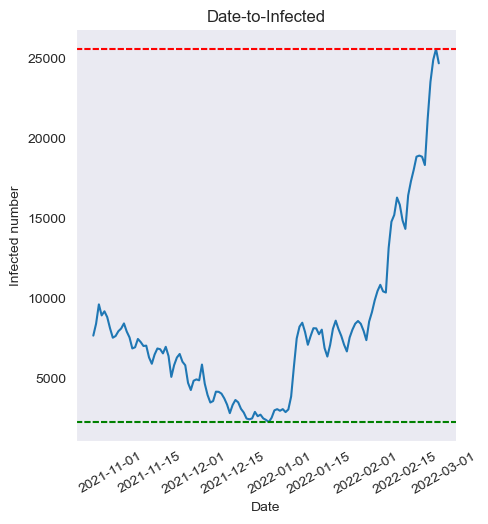

2.1.1 คำถาม : ณ วันที่มีการประกาศ วันใดที่มีจำนวนผู้ติดเชื้อสูงสุดและต่ำสุด และมีจำนวนเท่าใดบ้าง
Answer : 
	A maximum number of infected people : 25,615 people (red dash line) on 2022-02-26.
	A minimum number of infected people : 2,305  people (green dash line) on 2021-12-28.


In [6]:
### 2.1.1 คำถาม : ณ วันที่มีการประกาศ วันใดที่มีจำนวนผู้ติดเชื้อสูงสุดและต่ำสุด และมีจำนวนเท่าใดบ้าง

sns.set_style("dark")

graph = sns.relplot(x= 'announce_date', y='no.', data=date_infected, kind='line')
graph.set(xlabel="Date", ylabel='Infected number', title='Date-to-Infected')

graph.map(plt.axhline, y= date_infected['no.'].max(), color='r', dashes=(3,1))
graph.map(plt.axhline, y= date_infected['no.'].min() , color='g', dashes=(3,1))

plt.xticks(rotation=30)
plt.show()

print("2.1.1 คำถาม : ณ วันที่มีการประกาศ วันใดที่มีจำนวนผู้ติดเชื้อสูงสุดและต่ำสุด และมีจำนวนเท่าใดบ้าง")
print("Answer : ")
print(f"\tA maximum number of infected people : {date_infected['no.'].max():,} people (red dash line) on {date_infected[date_infected['no.'] == date_infected['no.'].max()].iloc[0,0].date()}.")
print(f"\tA minimum number of infected people : {date_infected['no.'].min():,}  people (green dash line) on {date_infected[date_infected['no.'] == date_infected['no.'].min()].iloc[0,0].date()}.")

### 2.1.2 คำถาม : ข้อมูลของเพศมีการกระจายตัวแบบใด และทั้ง 2 เพศนั้นอายุใดที่ติดเชื้อ Covid มากที่สุด

In [7]:
### 2.1.2 คำถาม : ข้อมูลของเพศมีการกระจายตัวแบบใด และทั้ง 2 เพศนั้นอายุใดที่ติดเชื้อ Covid มากที่สุด

def isNaN(number) :     #### วิธีว่าเป็น NaN ไหม 
    return number != number 

age_count = df[['age_year', "sex", "no."]].groupby(["age_year", "sex"], as_index=False).agg("count")

for i in range(len(age_count)) :
    if (int(age_count.loc[i, "age_year"]) > 100) or (int(age_count.loc[i, "age_year"]) < 0) :
        age_count.drop(i, axis=0, inplace=True)

sex_eng = {"หญิง":'Female', "ชาย":'Male'}
age_count['sex'] = age_count['sex'].map(sex_eng)

age_count_male = age_count[age_count['sex'] == 'Male']
age_count_female = age_count[age_count['sex'] == 'Female']

In [8]:
age_count.dropna(subset=['sex'], inplace=True)

fig = px.scatter(age_count, x=age_count['age_year'], y=age_count['no.'], color='sex',
           labels={"no.":"Infected number", "age_year":"Age"},
           title= "Infect numbers by Ages and Sex")

#fig.add_vrect(x0=age_count.loc[age_count['no.'] == age_count['no.'].max(), 'age_year'].values[0],
# x1=1000, annotation_text = 'Highest age = 25', annotation_position = 'right')

fig.add_vline(x= age_count.loc[age_count['no.'] == age_count['no.'].max(), 'age_year'].values[0],
             line_width = 3, line_dash="dash", fillcolor='green', 
              annotation_text = '    Highest infected number at age = 25', annotation_position = 'top right', 
             annotation_font_size=20, annotation_font_color="blue")

fig.show()

#### 'age_year' == 0 คือ กลุ่มที่มีอายุอยู่ในช่วง 0 - 1 ปี

print("คำถาม : ข้อมูลของเพศมีการกระจายตัวแบบใด และทั้ง 2 เพศนั้นอายุใดที่ติดเชื้อ Covid มากที่สุด")
print("Answer : ")
print("\tจากกราฟ จะเห็นได้ว่า ข้อมูลมีการกระจายตัวแบบ Positive skewness ทั้งเพศชายและเพศหญิง")
print("โดยช่วงอายุที่มีการติดเชื้อ Covid มากที่สุดคือช่วงอายุ 25 ปีทั้งในเพศชายและเพศหญิงเช่นกัน")
print(f"เพศชาย อายุ 25 ปี : {age_count_female['no.'].max():,}  คน")
print(f"เพศหญิง อายุ 25 ปี : {age_count_male['no.'].max():,}  คน")

คำถาม : ข้อมูลของเพศมีการกระจายตัวแบบใด และทั้ง 2 เพศนั้นอายุใดที่ติดเชื้อ Covid มากที่สุด
Answer : 
	จากกราฟ จะเห็นได้ว่า ข้อมูลมีการกระจายตัวแบบ Positive skewness ทั้งเพศชายและเพศหญิง
โดยช่วงอายุที่มีการติดเชื้อ Covid มากที่สุดคือช่วงอายุ 25 ปีทั้งในเพศชายและเพศหญิงเช่นกัน
เพศชาย อายุ 25 ปี : 12,154  คน
เพศหญิง อายุ 25 ปี : 10,028  คน


### 2.1.3 คำถาม : จำนวนชาวต่างชาติที่ติดเชื้อCovid ที่อยู่ในประเทศไทยมีจำนวนเท่าใด และ Top10 ประกอบไปด้วยเชื้อชาติใดบ้าง

In [9]:
### 2.1.3 คำถาม : จำนวนชาวต่างชาติที่ติดเชื้อCovid ที่อยู่ในประเทศไทยมีจำนวนเท่าใด และ Top10 ประกอบไปด้วยเชื้อชาติใดบ้าง

other_nationality = df[(df['nationality_adjust'] != 'Thai') & (df['nationality_adjust'].isna()==False)& (df['province_of_isolation'].isna() ==False) ]
other_nationality[['age_year']].describe()

age_year
count  44941.000000
mean      32.731626
std       16.060461
min       -1.000000
25%       24.000000
50%       32.000000
75%       42.000000
max      158.000000

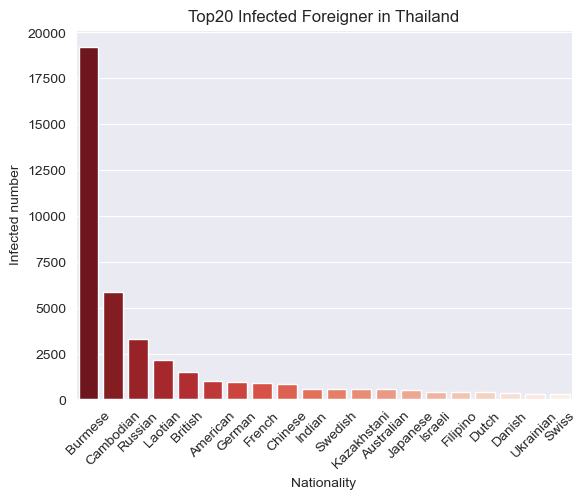

คำถาม : จำนวนชาวต่างชาติที่ติดเชื้อCovid ที่อยู่ในประเทศไทยมีจำนวนเท่าใด และ Top10 ประกอบไปด้วยเชื้อชาติใดบ้าง
Answer : 
	 จำนวนชาวต่างชาติที่ติดเชื้อCovid ที่อยู่ในประเทศไทย มีทั้งหมด 44,941 คน (ที่สามารถระบุได้ว่า อยู่ในประเทศไทย) 
	 Top 10 nationality : 
['Burmese', 'Cambodian', 'Russian', 'Laotian', 'British', 'American', 'German', 'French', 'Chinese', 'Indian'] respectively.


In [10]:
ranking_max_min = other_nationality['nationality_adjust'].value_counts().sort_values(ascending=False).index

sns.set_style("darkgrid")

b_palette = sns.color_palette("Reds", n_colors=20)
b_palette.reverse()

graph3 = sns.countplot(x='nationality_adjust' , data=other_nationality, order=ranking_max_min[0:20] ,palette=b_palette)
graph3.set(xlabel='Nationality', ylabel='Infected number', title='Top20 Infected Foreigner in Thailand' )

plt.xticks(rotation=45)
plt.show()


print("คำถาม : จำนวนชาวต่างชาติที่ติดเชื้อCovid ที่อยู่ในประเทศไทยมีจำนวนเท่าใด และ Top10 ประกอบไปด้วยเชื้อชาติใดบ้าง")
print("Answer : ")
print(f"\t จำนวนชาวต่างชาติที่ติดเชื้อCovid ที่อยู่ในประเทศไทย มีทั้งหมด {other_nationality['age_year'].count():,} คน (ที่สามารถระบุได้ว่า อยู่ในประเทศไทย) ")
print(f"\t Top 10 nationality : \n{ [i for i in ranking_max_min[0:10].values ] } respectively.")

# Insight Story

## 2.2 การแพร่เชื้อของ Covid

### 2.2.1 อยากทราบว่า เหตุผลที่ผู้ติดเชื้อกล่าวมา ส่วนใหญ่มาจากแหล่งใดเป็นหลัก


In [11]:
# Insight Story
## 2.2 การแพร่เชื้อของ Covid

### 2.2.1 อยากทราบว่า เหตุผลที่ผู้ติดเชื้อกล่าวมา ส่วนใหญ่มาจากแหล่งใดเป็นหลัก


#### แรกเริ่ม จะดูภาพรวมก่อนว่า ในช่วงเวลาทั้งหมด 4 เดือนกว่านี้ มาจากสาเหตุใดบ้างเยอะที่สุด

print(f"จำนวนวันที่ทำการเก็บข้อมูลมีทั้งหมด {(df['announce_date'].max() - df['announce_date'].min()).days} วัน")
print(f"ตั้งแต่วันที่ {df['announce_date'].min().strftime('%d-%m-%Y')} จนกระทั่ง {df['announce_date'].max().strftime('%d-%m-%Y')}")

print("\nสาเหตุถูกแบ่งกลุ่มเป็นทั้งหมด 8 กลุ่ม และสามารถเรียงได้ดังนี้")
print(df['risk_group'].value_counts().sort_values(ascending=False))
print(f"\nจะเห็นได้ว่า สาเหตุหลักจะมาจากการ'สัมผัสผู้ติดเชื้อCovid'(G1) ถึงร้อยละ {round((df['risk_group'].value_counts().sort_values(ascending=False).values[0] / df['risk_group'].value_counts().sort_values(ascending=False).sum()),2)}")
print(f"และสาเหตุรองลงมา คือ 'อื่นๆ'(G8) ถึงร้อยละ {round((df['risk_group'].value_counts().sort_values(ascending=False).values[1] / df['risk_group'].value_counts().sort_values(ascending=False).sum()),2)}")

จำนวนวันที่ทำการเก็บข้อมูลมีทั้งหมด 124 วัน
ตั้งแต่วันที่ 26-10-2021 จนกระทั่ง 27-02-2022

สาเหตุถูกแบ่งกลุ่มเป็นทั้งหมด 8 กลุ่ม และสามารถเรียงได้ดังนี้
สัมผัสผู้ติดเชื้อCovid         461478
อื่นๆ                          346812
สถานที่และงาน                   90803
อยู่ขั้นตอนการสอบสวน            70939
การสำรวจและหาเชื้อเชิงลึก_      15845
นโยบายส่งเสริมการท่องเที่ยว     11660
กลุ่มบุคลากรทางการแพทย์         10888
กลุ่มมาจากต่างประเทศ             2034
Name: risk_group, dtype: int64

จะเห็นได้ว่า สาเหตุหลักจะมาจากการ'สัมผัสผู้ติดเชื้อCovid'(G1) ถึงร้อยละ 0.46
และสาเหตุรองลงมา คือ 'อื่นๆ'(G8) ถึงร้อยละ 0.34


In [12]:
#### กำหนดให้
#### G1 : 'สัมผัสผู้ติดเชื้อCovid', G2 : 'อยู่ขั้นตอนการสอบสวน', G3 : 'สถานที่และงาน', G4 : 'การสำรวจและหาเชื้อเชิงลึก'
#### G5 : 'นโยบายส่งเสริมการท่องเที่ยว', G6 : 'กลุ่มบุคลากรทางการแพทย์', G7 : 'กลุ่มมาจากต่างประเทศ', G8 : 'อื่นๆ'

dict_G = { 'G1' : 'สัมผัสผู้ติดเชื้อCovid', 'G2' : 'อยู่ขั้นตอนการสอบสวน', 'G3' : 'สถานที่และงาน', 'G4' : 'การสำรวจและหาเชื้อเชิงลึก_', 
         'G5' : 'นโยบายส่งเสริมการท่องเที่ยว', 'G6' : 'กลุ่มบุคลากรทางการแพทย์', 'G7' : 'กลุ่มมาจากต่างประเทศ', 'G8' : 'อื่นๆ'}

def risk_change_to_eng(df, column) :
    for i in range(len(df[column])) :
        for j in dict_G.items() :
            if df.loc[i, column] == j[1] :
                df.loc[i, column] = j[0]

In [13]:
#### ที่นี้มาดูแบบรายเดือนว่า เหตุผลที่กล่าวมานั้น หลักๆมาจากช่วงเวลาไหน

df['announce_month'] = pd.DatetimeIndex(df['announce_date']).month_name() + '_' + pd.DatetimeIndex(df['announce_date']).strftime('%Y')

sorter = ['October_2021', 'November_2021', 'December_2021', 'January_2022', 'February_2022']

month_risk = df.groupby(["announce_month", "risk_group"], as_index=False).agg("count").sort_values(by=["announce_month", "no."], ascending=False)
month_risk = month_risk[['announce_month',"risk_group", 'no.']]

risk_change_to_eng(month_risk, 'risk_group')

month_risk['announce_month'] = month_risk['announce_month'].astype("category")
month_risk.announce_month.cat.set_categories(sorter, inplace=True)
month_risk.sort_values(by=['announce_month', 'risk_group'])

month_risk_crosstable = pd.crosstab(month_risk['risk_group'], month_risk['announce_month'], values=month_risk['no.'],aggfunc="sum")
month_risk_crosstable.sort_values(by='October_2021', ascending=False)

C:\Users\pongp\anaconda3\envs\DADS4002\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning:

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.



announce_month  October_2021  November_2021  December_2021  January_2022  \
risk_group                                                                 
G1                     27119         100170          50483         97553   
G8                     14662          56386          37390         73604   
G2                      4828          15101           4319         17372   
G3                      3366          23146          10742         16919   
G4                      2464           6906           2290          1736   
G6                       358           1730           1114          2897   
G7                        49            267            265           834   
G5                        21            142            960          6192   

announce_month  February_2022  
risk_group                     
G1                     186153  
G8                     164770  
G2                      29319  
G3                      36630  
G4                       2449  
G6                       4789  
G7                        619  
G5                       4345

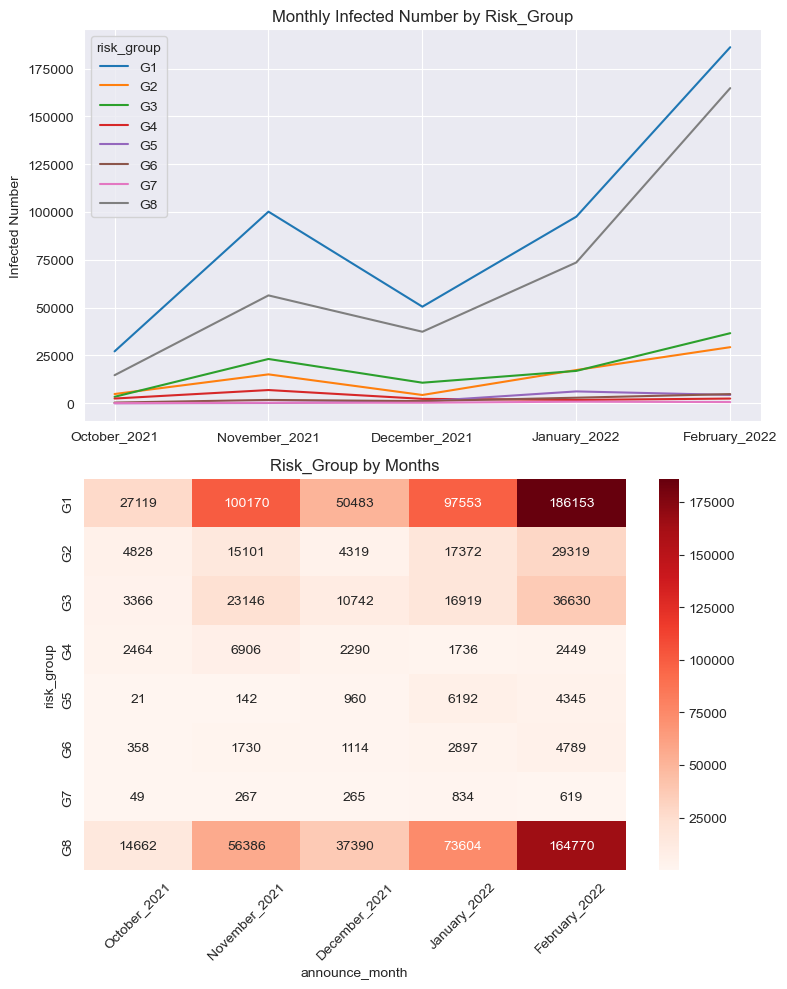

{'G1': 'สัมผัสผู้ติดเชื้อCovid', 'G2': 'อยู่ขั้นตอนการสอบสวน', 'G3': 'สถานที่และงาน', 'G4': 'การสำรวจและหาเชื้อเชิงลึก_', 'G5': 'นโยบายส่งเสริมการท่องเที่ยว', 'G6': 'กลุ่มบุคลากรทางการแพทย์', 'G7': 'กลุ่มมาจากต่างประเทศ', 'G8': 'อื่นๆ'}

ภาพรวม จะเห็นได้ว่า จำนวนผู้ติดเชื้อCovid มาจากช่วงเดือน Noverber_2021, Januaryr_2022 และ February_2022 
โดยจะพบมากที่สุดในเดือนสุดท้าย
และตัว heatmap ได้ย้ำให้เห็นว่า จำนวนผู้ติดเชื้อส่วนใหญ่มาจากปัจจัยทางด้าน สัมผัสผู้ติดเชื้อCovid (G1) & เหตุผลอื่น (G8) นั่นเอง


In [14]:
fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8,10))

ax0 = sns.lineplot(data=month_risk, x='announce_month', y='no.', hue='risk_group',
             hue_order=['G1','G2','G3','G4','G5','G6','G7','G8'], ax=ax0)
ax0.set(title='Monthly Infected Number by Risk_Group', ylabel='Infected Number', xlabel='')

ax1 = sns.heatmap(month_risk_crosstable, cbar=True, cmap="Reds", annot=True, fmt="d", xticklabels=sorter, ax=ax1).set(title='Risk_Group by Months')

#G1 = ['สัมผัสใกล้ชิดกับผู้ป่วยยืนยันรายก่อนหน้านี้','2.สัมผัสผู้ติดเชื้อ', 'สัมผัสผู้ป่วยยืนยันภายในชุมชน', 'เดินทางมาจากพื้นที่ระบาด', 'ในพื้นที่',  'เดินทางมาจากพื้นที่เสี่ยงที่มีการระบาดของโรค','เพื่อเฝ้าระวังเชื้อกลายพันธุ์', 'สัมผัสใกล้ชิดกับผู้ป่วยยืนยันรายก่อนหน้านี้ใกล้ชิดกับผู้ป่วยยืนยันรายก่อนหน้านี้', 'ติดเชื้อในพื้นที่ (สัมผัส ผป.ยืนยัน)','9.ขอตรวจหาเชื้อเอง']
#G2 = ['อยู่ระหว่างการสอบสวน','อยู่ระหว่างสอบสวนโรค']
#G3 = ['สถานที่ทำงาน', 'ทัณฑสถาน/เรือนจำ','สถานศึกษา', 'สถานบันเทิง','พิธีกรรมทางศาสนา','สนามมวย','ไปสถานที่ชุมชน','ศูนย์กักกัน ผู้ต้องกัก', 'ร่วมงานศพในหมู่บ้านทุกวัน', 'สถานประกอบการ','กลับมาจาก จ.กรุงเทพมหานคร.', 
#           'ไปสถานที่ชุมชน เช่น ตลาดนัด สถานที่ท่องเที่ยว' ,'ไปสถานที่แออัด เช่น งานแฟร์ คอนเสิร์ต', 'นักกีฬา','อาชีพเสี่ยง เช่น ทำงานในสถานที่แออัด หรือทำงานใกล้ชิดสัมผัสชาวต่างชาติ เป็นต้น','มีอาการ มาจาก กรุงเทพมหานคร. พนักงานร้านอาหาร']
#G4 = ['การค้นหาผู้ป่วยเชิงรุกและค้นหาผู้ติดเชื้อในชุมชน', '8.สำรวจกลุ่มเสี่ยง (survey)']
#G5 = ['Phuket Sandbox','Test and Go',  'Samui plus', 'Chonburi Sandbox','Phang Nga Sandbox','BKK Sandbox', 'Krabi Sandbox', 'Phunga Sandbox', 'Karbi Sandbox',
#           'Samut Prakan Sandbox','Prachuap Sandbox', 'Songkhla Sandbok','Samui Plus', 'Narathiwat Sandbox', 'Phang nga Sandbox','Rayong Sandbox',  'Phare Sandbox', 'Trat Sandbox', 'Krabi sandbox ', 'Krabi Sandbox ', 'Phrae Sandbox', 'Udon Sandbox', 'prachuap Sandbox','Trat sandbox']
#G6 = [ 'ตรวจก่อนทำหัตถการ','บุคลากรด้านการแพทย์และสาธารณสุข', 'ตรวจก่อนทำหัถตการ','บุคลากรทางการเเพทย์']
#G7 = [ 'ผู้ที่เดินทางมาจากต่างประเทศ และเข้า OQ', 'ผู้ที่เดินทางมาจากต่างประเทศ และเข้า AQ','State Quarantine','คนต่างชาติเดินทางมาจากต่างประเทศ',  'คนไทยเดินทางกลับจากต่างประเทศ','ผู้ที่เดินทางมาจากต่างประเทศ และเข้า HQ/AHQ', 'สัมผัสผู้เดินทางจากต่างประเทศ']
#G8 = ['อื่นๆ','ระบุไม่ได้', 'ปอดอักเสบ (Pneumonia)', '10.อื่นๆ']

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(dict_G)
print('\nภาพรวม จะเห็นได้ว่า จำนวนผู้ติดเชื้อCovid มาจากช่วงเดือน Noverber_2021, Januaryr_2022 และ February_2022 \nโดยจะพบมากที่สุดในเดือนสุดท้าย')
print('และตัว heatmap ได้ย้ำให้เห็นว่า จำนวนผู้ติดเชื้อส่วนใหญ่มาจากปัจจัยทางด้าน สัมผัสผู้ติดเชื้อCovid (G1) & เหตุผลอื่น (G8) นั่นเอง')

### 2.2.2 ชาวต่างชาติกับคนไทยคิดเป็นสัดส่วนเท่าไหร่ในแต่ละพื้นที่ ลักษณะการแพร่เชื้อในแต่ละจังหวัดของCovid มากน้อยเพียงใด และในจังหวัดที่ชาวต่างชาติติดเชื้อสูงๆ มีแนวโน้มการแพร่เชื้อมาจากลักษณะใด

<ipython-input-15-7718f9af2da7>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-7718f9af2da7>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



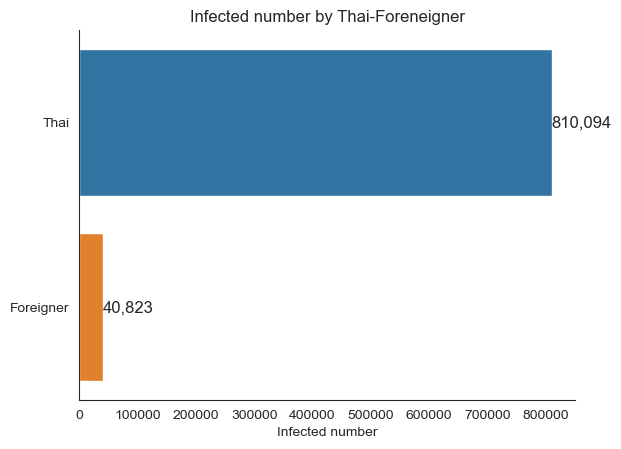

แสดงว่า อัตราส่วนของคนต่างชาติต่อคนไทยที่ติดเชื้อ Covid คือ 40,823 : 810,094  หรือประมาณ 5% ของจำนวนประชากรไทยที่ติด Covid ทั้งหมด



In [15]:
### 2.2.2 ชาวต่างชาติกับคนไทยคิดเป็นสัดส่วนเท่าไหร่ในแต่ละพื้นที่ ลักษณะการแพร่เชื้อของCovid ขยายตัวออกเป็นอย่างไร และชาวต่างชาติเป็นผู้กระจายเชื้อในประเทศไทยใช่ไหม
#### เริ่มจากเช็คก่อนว่า สัดส่วนภาพรวมแตกต่างกันอย่างไร

thai_people = df[(df['nationality_adjust'] == 'Thai') & (df['nationality_adjust'].isna() == False)]
thai_people['count'] = 1
foreign_people = df[(df['nationality_adjust'] != 'Thai') & (df['nationality_adjust'].isna() == False)]
foreign_people['count'] = 1

thai_foreign = pd.concat([thai_people, foreign_people])
thai_foreign['count'] = 1

thai_people = thai_people[thai_people['province_of_onset'].isna() == False]
foreign_people = foreign_people[foreign_people['province_of_onset'].isna() == False]
thai_foreign = thai_foreign[thai_foreign['province_of_onset'].isna() == False]

foreign_people_sum = pd.DataFrame((('Thai', thai_people['count'].sum()), ('Foreigner', foreign_people['count'].sum())) , columns=['people', 'total'])

sns.set_style('white')
fig3 = sns.barplot(y='people',x='total', data=foreign_people_sum)#, height=5, aspect=.8)

fig3.set(ylabel='', xlabel='Infected number', title='Infected number by Thai-Foreneigner')

fig3.bar_label(fig3.containers[0], size=12, labels=[f'{num:,.0f}' for num in fig3.containers[0].datavalues])

fig3.spines['right'].set_visible(False)
fig3.spines['top'].set_visible(False)

plt.show()

print(f"""แสดงว่า อัตราส่วนของคนต่างชาติต่อคนไทยที่ติดเชื้อ Covid คือ {foreign_people_sum['total'][1]:,} : {foreign_people_sum['total'][0]:,}  หรือประมาณ {round(int(foreign_people_sum['total'][1]) /int(foreign_people_sum['total'][0]), 2) :.0%} ของจำนวนประชากรไทยที่ติด Covid ทั้งหมด
""")

In [16]:
#### แล้วเช็คต่อว่าการแพร่นี้กระจายมาจากจังหวัดใดบ้าง(ยึดจาก province_of_onset) และลองเช็คในจังหวัดที่สำคัญหรือมีจำนวนผู้ติดเชื้อ Covid สูงๆ

px1 = px.sunburst(thai_people, path=['nationality_adjust', 'province_of_onset'], values= 'count', title='Infected Thai by provinces' )
px1.show()
print(f"Top 12 จังหวัดที่พบคนไทยติดเชื้อ Covid :  \n(ใช้จำนวน 12 จังหวัดเพราะเป็นจำนวนประมาณครึ่งนึงของจำนวนคนไทยที่ติดเชื้อทั้งหมด)")

thai_people_infected = pd.DataFrame(thai_people['province_of_onset'].value_counts()[0:12]).rename(columns={"province_of_onset":"Infected number"})
append_1 = pd.DataFrame([thai_people['province_of_onset'].value_counts()[13:].sum()], columns=['Infected number'], index=['จังหวัดอื่นๆ'])
thai_people_infected.append(append_1)

Top 12 จังหวัดที่พบคนไทยติดเชื้อ Covid :  
(ใช้จำนวน 12 จังหวัดเพราะเป็นจำนวนประมาณครึ่งนึงของจำนวนคนไทยที่ติดเชื้อทั้งหมด)


Infected number
กรุงเทพมหานคร           116550
ชลบุรี                   47829
สมุทรปราการ              42717
นนทบุรี                  32719
นครศรีธรรมราช            26939
สงขลา                    26539
ระยอง                    19706
ภูเก็ต                   19402
ปทุมธานี                 18221
สุราษฎร์ธานี             17328
นครปฐม                   16681
อุบลราชธานี              16453
จังหวัดอื่นๆ            393124

In [17]:
foreign_people['nationality_adjust'] = 'Other_nationality'
px2 = px.sunburst(foreign_people, path=['nationality_adjust','province_of_onset'], values= 'count', title='Infected Foreigner by provinces' )

px2.show()
print(f"ขณะที่ Top 12 จังหวัดที่พบคนต่างชาติติดเชื้อ Covid : ")

foreign_people_infected = pd.DataFrame(foreign_people['province_of_onset'].value_counts()[0:12]).rename(columns={"province_of_onset":"Infected number"})
append_2 = pd.DataFrame([foreign_people['province_of_onset'].value_counts()[13:].sum()], columns=['Infected number'], index=['จังหวัดอื่นๆ'])
foreign_people_infected.append(append_2)

ขณะที่ Top 12 จังหวัดที่พบคนต่างชาติติดเชื้อ Covid : 


Infected number
กรุงเทพมหานคร               6343
ภูเก็ต                      5042
ชลบุรี                      3717
สมุทรปราการ                 3004
ประจวบคีรีขันธ์             2181
สุราษฎร์ธานี                2156
ระยอง                       1708
สมุทรสาคร                   1621
นนทบุรี                     1559
ตาก                         1274
ราชบุรี                     1029
ตราด                         889
จังหวัดอื่นๆ                9413

แสดงว่า จะมีทั้งหมด 7 จังหวัดที่มีคนติดเชื้อCovid ทั้งคนไทยและต่างชาติตามภาพด้านล่าง
ใน 7 จังหวัดนี้ มีอยู่ 2 จังหวัดคือ ภูเก็ต และ สุราษฎร์ธานี ที่มีอัตราส่วนของคนติดเชื้อระหว่างคนไทยและคนต่างชาติ เกิน 10%



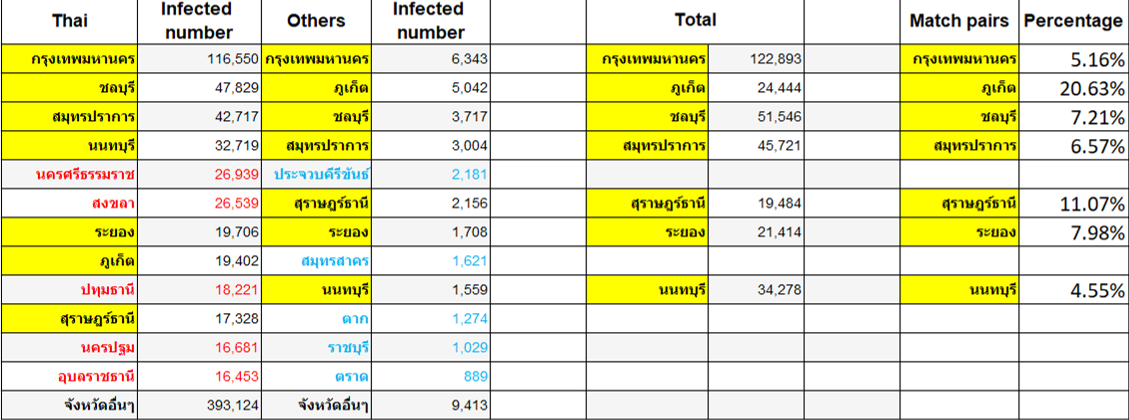

In [18]:
from PIL import Image

print(f'แสดงว่า จะมีทั้งหมด 7 จังหวัดที่มีคนติดเชื้อCovid ทั้งคนไทยและต่างชาติตามภาพด้านล่าง')
print(f"ใน 7 จังหวัดนี้ มีอยู่ 2 จังหวัดคือ ภูเก็ต และ สุราษฎร์ธานี ที่มีอัตราส่วนของคนติดเชื้อระหว่างคนไทยและคนต่างชาติ เกิน 10%\n")

Image.open("Picture1.png")

C:\Users\pongp\anaconda3\envs\DADS4002\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\pongp\anaconda3\envs\DADS4002\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



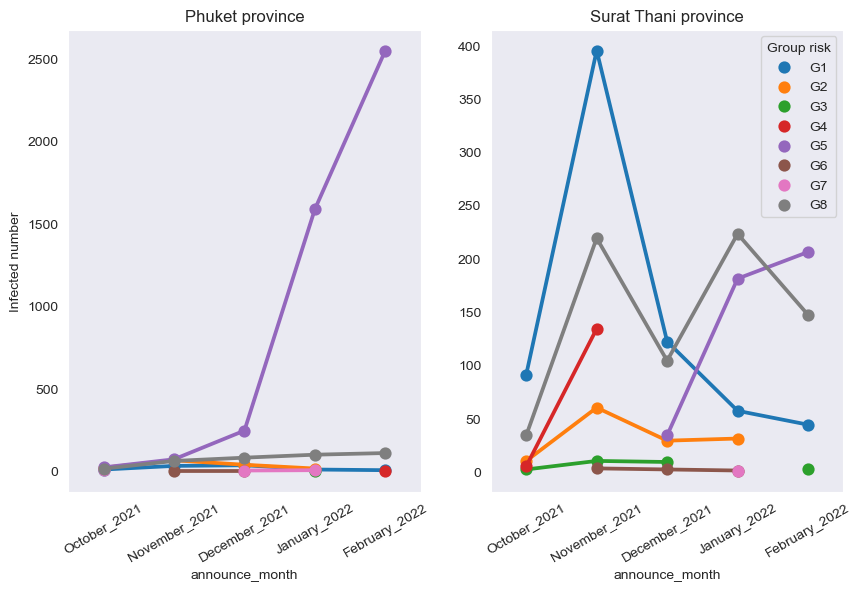

ซึ่งสาเหตุหลักที่ก่อให้เกิดคนต่างชาติติดเชื้อมากในประเทศไทย มีดังต่อไปนี้
ในจังหวัดภูเก็ต จากข้อมูลด้านบน แสดงให้เห็นว่า นโยบายส่งเสริมการท่องเที่ยว(G5)ของภาครัฐเป็นปัจจัยสำคัญที่ก่อให้เกิดการแพร่เชื้อในจังหวัดนี้
ในขณะที่จังหวัดสุราษฎร์ธานี ชาวต่างชาติที่มีการติดเชื้อส่วนใหญ่มาจาก การสัมผัสผู้ติดเชื้อCovid(G1) และ การสำรวจและหาเชื้อเชิงลึก(G3) 
ซึ่งเป็นปัจจัยภายในประเทศมากกว่าจะเป็นปัจจัยจากต่างประเทศ
ดังนั้น ข้อมูลแสดงให้เห็นว่า แม้ว่าจะมีคนต่างชาติติดในบางจังหวัดเยอะเมื่อเทียบสัดส่วนกับคนไทย แต่ปัจจัยที่ทำให้เกิดการแพร่เชื้ออาจมาจากเหตุผลคนละแบบ จึงมิอาจสรุปได้ว่า ชาวต่างชาติเป็นผู้แพร่กระจายเชื้อCovid ในประเทศไทย


In [29]:
foreign_p1 = pd.DataFrame(foreign_people[foreign_people['province_of_onset'] == 'ภูเก็ต'].value_counts(['announce_month', 'risk_group'])
, columns=['sum']).reset_index()
foreign_p2 = pd.DataFrame(foreign_people[foreign_people['province_of_onset'] == 'สุราษฎร์ธานี'].value_counts(['announce_month', 'risk_group'])
, columns=['sum']).reset_index()

risk_change_to_eng(foreign_p1, 'risk_group')
risk_change_to_eng(foreign_p2, 'risk_group')

sns.set_style("dark")

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

sns.pointplot(foreign_p1['announce_month'], foreign_p1['sum'], order=sorter,
              hue=foreign_p1['risk_group'], marker='o', hue_order=['G1','G2','G3','G4','G5','G6','G7','G8'],
              ax=ax0)

sns.pointplot(foreign_p2['announce_month'], foreign_p2['sum'], order=sorter,
              hue=foreign_p2['risk_group'], marker='o', hue_order=['G1','G2','G3','G4','G5','G6','G7','G8'],
              ax=ax1)

#ax0.set_ylim(ax1.get_ylim())

ax0.set_xticklabels(ax0.get_xticklabels(), rotation=30)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)

ax0.set_title("Phuket province")
ax1.set_title("Surat Thani province")

ax0.set_ylabel('Infected number')
ax1.set_ylabel('')

ax0.get_legend().remove()
ax1.legend(loc='upper right', title='Group risk')
plt.show()

print("ซึ่งสาเหตุหลักที่ก่อให้เกิดคนต่างชาติติดเชื้อมากในประเทศไทย มีดังต่อไปนี้")
print("ในจังหวัดภูเก็ต จากข้อมูลด้านบน แสดงให้เห็นว่า นโยบายส่งเสริมการท่องเที่ยว(G5)ของภาครัฐเป็นปัจจัยสำคัญที่ก่อให้เกิดการแพร่เชื้อในจังหวัดนี้")
print("ในขณะที่จังหวัดสุราษฎร์ธานี ในช่วง2เดือนแรก ชาวต่างชาติที่มีการติดเชื้อส่วนใหญ่มาจาก การสัมผัสผู้ติดเชื้อCovid(G1) และ การสำรวจและหาเชื้อเชิงลึก(G4) \nซึ่งเป็นปัจจัยภายในประเทศมากกว่าจะเป็นปัจจัยจากต่างประเทศ กล่าวคือเค้าติดเชื้อกันจากในประเทศไทย  ทว่าในช่วง 3 เดือนสุดท้าย กลับมีสัญญาณมาจากปัจจัยภายนอกเกิดขึ้น โดยในเหตุผลเกี่ยวกับนโยบายส่งเสริมการท่องเที่ยว(G5) เป็น risk ที่เกิดขึ้นสูงสุดในจังหวัดนี้")
print("ดังนั้น แม้ว่าจะมีคนต่างชาติติดในบางจังหวัดเยอะเมื่อเทียบสัดส่วนกับคนไทย เช่น จังหวัดภูเก็ตและสุราษฎร์ธานี แนวโน้มที่ทำให้เกิดการแพร่เชื้อในช่วงปีที่แล้วอาจมาจากคนละปัจจัย แต่ในช่วงปี 2022 กลับมีลักษณะไปในทางเดียวกันคือมาจากนโยบายส่งเสริมการท่องเที่ยว(G5)")

### 2.2.3 ความสัมพันธ์ระหว่าง risk กับลักษณะการแพร่เชื้อ : ทำไมหนุ่มสาววัยกลางคนถึงมีจำนวนผู้ติดเชื้อCovid มากกว่าวัยอื่นๆ และเราควรจะเฝ้าระวังปัจจัยใดเป็นพิเศษบ้าง

In [20]:
### 2.2.3 ความสัมพันธ์ระหว่าง risk กับลักษณะการแพร่เชื้อ ทำไมหนุ่มสาววัยกลางคนถึงมีจำนวนผู้ติดเชื้อCovid มากกว่าวัยอื่นๆ และเราควรจะเฝ้าระวังปัจจัยใดเป็นพิเศษบ้าง

#### เริ่มจาก define ก่อนว่าวัยกลางคนในที่นี้คือคนในช่วงอายุใด

age_count_all = age_count.groupby("age_year").agg("sum")
age_count_all.describe()

no.
count    101.000000
mean    8841.653465
std     6495.186508
min       27.000000
25%     2478.000000
50%     9041.000000
75%    12774.000000
max    22182.000000

In [21]:
print('\tจากกราฟข้อ 2.1.2 แสดงให้เห็นว่า ช่วงวัยกลางคนมีจำนวนผู้ติดเชื้อมากเมื่อเทียบกับวัยกลุ่มอื่นๆ โดยจะทำการแบ่งกลุ่มโดยอาศัยจากหลักเกณฑ์ดังนี้')
print(f"""\tจากกราฟด้านล่าง เป็นการนับรวมทั้งเพศหญิงและเพศชาย จะได้จำนวนคนติดเชื้อ Covid ในแต่ละอายุ)
จะเห็นได้ว่า จำนวนที่มีค่าสูงมาก ซึ่งมีค่ามากกว่า > {int((age_count_all.mean() + age_count_all.std()).values[0]):,} (จากการนำค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานมารวมกัน : เส้นสีแดง)
จะได้ช่วงอายุ 20 - 40 ปีซึ่งเป็นกลุ่มคนที่มีจำนวนผู้ติดเชื้อมากกว่าวัยกลุ่มอื่น 
แต่ทั้งนี้ จะทำการแบ่งกลุ่มเป็นกลุ่มละ 10 ปี เพื่อเกิด scale ที่มองดูง่ายขึ้น""")

age_more_than_meanstd = []
for i in range(len(age_count_all)) :
    if age_count_all['no.'][i] >= (age_count_all.mean() + age_count_all.std()).values[0] :
        age_more_than_meanstd.append(age_count_all.index[i])

fig224 = px.scatter(age_count_all, x=age_count_all.index, y=age_count_all['no.'],
           labels={"no.":"Infected number", "age_year":"Age"},
           title= "Infect numbers by Ages")

fig224.add_hline( y= int((age_count_all.mean() + age_count_all.std()).values[0]) ,
             line_width = 3, line_dash="dash", line_color='red')
              
        
fig224.add_vrect( x0=min(age_more_than_meanstd) - 0.5 , x1=max(age_more_than_meanstd) +0.5,
                 line_width=0, fillcolor='orange', opacity=0.25,
                )

fig224.show()

	จากกราฟข้อ 2.1.2 แสดงให้เห็นว่า ช่วงวัยกลางคนมีจำนวนผู้ติดเชื้อมากเมื่อเทียบกับวัยกลุ่มอื่นๆ โดยจะทำการแบ่งกลุ่มโดยอาศัยจากหลักเกณฑ์ดังนี้
	จากกราฟด้านล่าง เป็นการนับรวมทั้งเพศหญิงและเพศชาย จะได้จำนวนคนติดเชื้อ Covid ในแต่ละอายุ)
จะเห็นได้ว่า จำนวนที่มีค่าสูงมาก ซึ่งมีค่ามากกว่า > 15,336 (จากการนำค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานมารวมกัน : เส้นสีแดง)
จะได้ช่วงอายุ 20 - 40 ปีซึ่งเป็นกลุ่มคนที่มีจำนวนผู้ติดเชื้อมากกว่าวัยกลุ่มอื่น 
แต่ทั้งนี้ จะทำการแบ่งกลุ่มเป็นกลุ่มละ 10 ปี เพื่อเกิด scale ที่มองดูง่ายขึ้น


	เมื่อนำมาแบ่งเป็น 10 กลุ่ม กลุ่มละ 10 ช่วงอายุ จะได้ดังนี้


<ipython-input-22-3c05d3b64963>:16: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



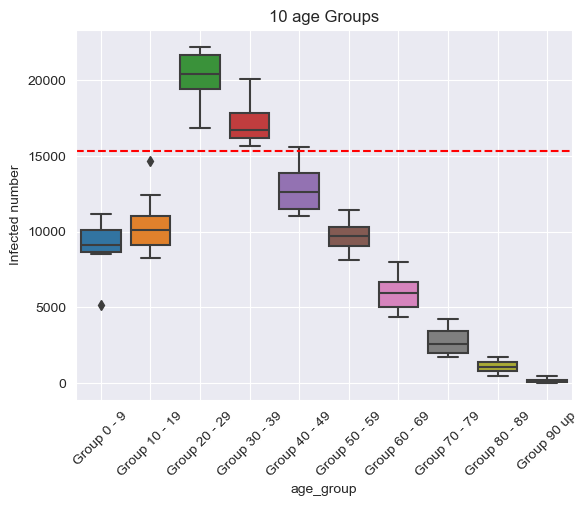

In [22]:
print('\tเมื่อนำมาแบ่งเป็น 10 กลุ่ม กลุ่มละ 10 ช่วงอายุ จะได้ดังนี้')

for i in age_count_all.reset_index()['age_year'].values :
    for j in range(0, len(age_count_all.reset_index()['age_year'].values)+1 ,10) :
        if 0+j <= i <= 9+j :
            age_count_all.loc[i, 'age_group'] =  f"Group {0+j} - {9+j}"
        if i >= 90 :
            age_count_all.loc[i, 'age_group'] =  f"Group 90 up"

sns.set_style("darkgrid")       
            
fig224_2 = sns.boxplot(data=age_count_all, y='no.', x='age_group')

fig224_2.set(ylabel='Infected number', title='10 age Groups')

plt.axhline(int((age_count_all.mean() + age_count_all.std()).values[0]), color='r', ls='--')

plt.grid(linestyle='-')
plt.xticks(rotation=45)
plt.show()

In [23]:
#### ทีนี้มาดูกันว่า ทำไมคน 2 กลุ่มนี้( Group 20-29 & Group 30-39) ถึงมีจำนวนที่สูงมากเมื่อเทียบกับกลุ่มอื่น

age_allgroups = df[(df['age_year'] <= 100) & (df['age_year'] >= 0) & (df['age_year'].isna() == False)][['age_year', 'risk_group', 'risk', 'province_of_isolation', 'province_of_onset', 'district_of_onset', 'nationality_adjust']]

age_allgroups_2 = age_allgroups.groupby(["age_year", "risk_group"]).agg({"risk":"count"}).reset_index()

for i in range(len(age_allgroups_2['risk_group'])) :
    for j in dict_G.items() :
        if age_allgroups_2.loc[i, 'risk_group'] == j[1] :
            age_allgroups_2.loc[i, 'risk_group'] = j[0]

for i in age_allgroups_2['age_year'].index :
    for j in range(0, 90 ,10) :
        if 0+j <= age_allgroups_2['age_year'][i] <= 9+j :
            age_allgroups_2.loc[i, 'age_group'] =  f"Group {0+j} - {9+j}"
        if age_allgroups_2['age_year'][i] >= 90 :
            age_allgroups_2.loc[i, 'age_group'] =  f"Group 90 up"        
            
age_allgroups_2 = age_allgroups_2.rename(columns={"risk":"total"})

age_allgroups_crosstable = pd.crosstab(age_allgroups_2['risk_group'], age_allgroups_2['age_group'], values=age_allgroups_2['total'],aggfunc="sum").fillna(0).astype("int")
age_allgroups_crosstable

age_group   Group 0 - 9  Group 10 - 19  Group 20 - 29  Group 30 - 39  \
risk_group                                                             
G1                57496          59088          94395          77910   
G2                 4731           5647          15460          13950   
G3                 3359           7536          23235          18216   
G4                 1598           1919           3238           2770   
G5                  561            533           2179           3418   
G6                  323            374           3523           2885   
G7                   57            155            595            544   
G8                25318          32809          66687          57431   

age_group   Group 40 - 49  Group 50 - 59  Group 60 - 69  Group 70 - 79  \
risk_group                                                               
G1                  60422          48269          31420          14847   
G2                   9412           6321           3496           1641   
G3                  13057           7593           3436           1298   
G4                   2278           1773           1081            503   
G5                   2125           1553            864            277   
G6                   1704           1019            482            305   
G7                    340            203            106             21   
G8                  43145          33281          20837           9601   

age_group   Group 80 - 89  Group 90 up  
risk_group                              
G1                   5974          995  
G2                    605           99  
G3                    408           76  
G4                    190           30  
G5                     25            1  
G6                    144           18  
G7                      4            0  
G8                   3981          633

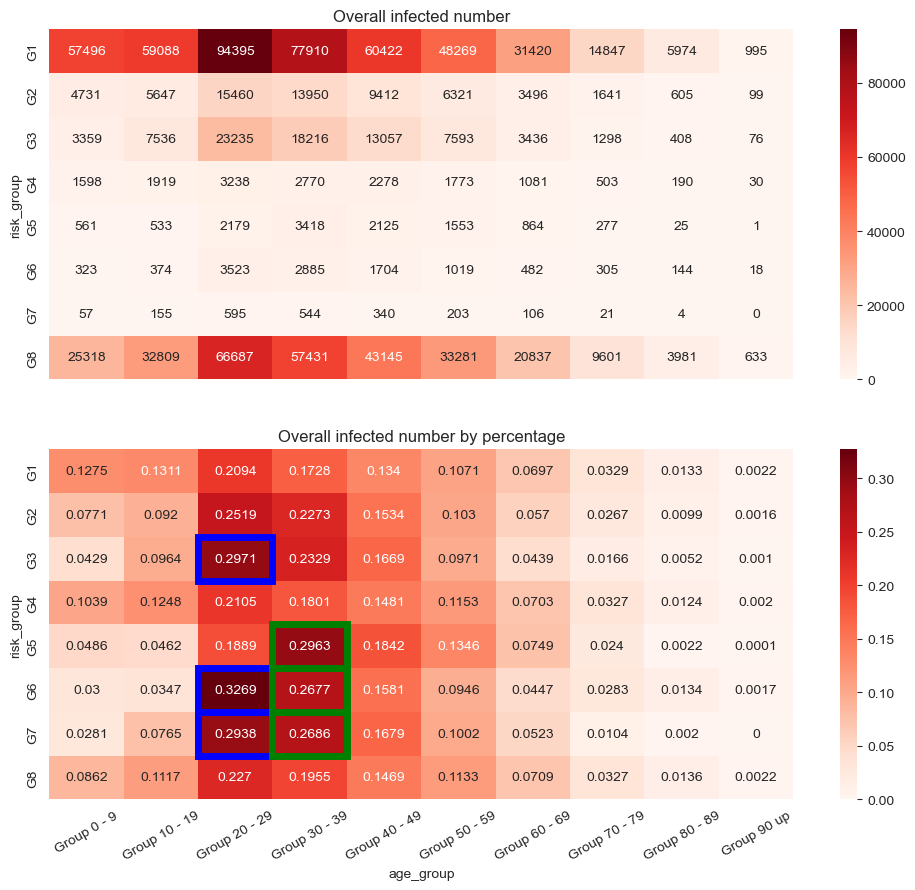

In [24]:
import matplotlib.patches as patches

fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

ht1 = sns.heatmap(age_allgroups_crosstable, cbar=True, cmap="Reds", annot=True, 
            fmt="d", ax=ax0, xticklabels='' )

ht2 = sns.heatmap(age_allgroups_crosstable.apply(lambda x : round((x/sum(x)), 4), axis=1), cbar=True, cmap="Reds", annot=True, 
            fmt="g", ax=ax1)

ht1.set(xlabel='', title='Overall infected number')
ht2.set(title='Overall infected number by percentage')
plt.xticks(rotation=30)

ax1.add_patch( patches.Rectangle((2, 2), 1, 1, linewidth=5, edgecolor='b', facecolor='none'))
ax1.add_patch( patches.Rectangle((2, 5), 1, 1, linewidth=5, edgecolor='b', facecolor='none'))
ax1.add_patch( patches.Rectangle((2, 6), 1, 1, linewidth=5, edgecolor='b', facecolor='none'))

ax1.add_patch( patches.Rectangle((3, 4), 1, 1, linewidth=5, edgecolor='g', facecolor='none'))
ax1.add_patch( patches.Rectangle((3, 5), 1, 1, linewidth=5, edgecolor='g', facecolor='none'))
ax1.add_patch( patches.Rectangle((3, 6), 1, 1, linewidth=5, edgecolor='g', facecolor='none'))

plt.show()

In [25]:
print("""จาก 2 กราฟ heatmap นี้ 
\t1.กราฟนี้ก็ยังแสดงให้เห็นว่า จำนวนโดยภาพรวมยังคงเป็นกลุ่มคน 2 กลุ่มคือช่วงอายุ 20-29 ปีและกลุ่ม 30-39 ปีที่มีจำนวนมากกว่ากลุ่มอื่นๆ ซึ่งจะมีเหตุผลมาจากการสัมผัสผู้ติดเชื้อCovid(G1) และสาเหตุอื่นๆ(G8)
\t2.ทว่า ในกราฟถัดมา เมื่อเทียบกันระหว่าง risk_group ในแต่ละช่วง
\t  ช่วงอายุ Group 20-29 : 
\t    สาเหตุเสี่ยงสำคัญที่ทำให้คนในวัยนี้ติดเชื้อ Covid มากกว่าวัยอื่นๆ (เทียบแนวนอน) คือ สถานที่และงาน(G3), กลุ่มบุคลากรทางการแพทย์(G6) และ กลุ่มมาจากต่างประเทศ(G7) ซึ่งมีอัตราส่วนมากถึง 30% ของแต่ละสาเหตุ
\t  ช่วงอายุ Group 30-39 : 
\t    สาเหตุเสี่ยงสำคัญที่ทำให้คนในวัยนี้ติดเชื้อ Covid มากกว่าวัยอื่นๆ (เทียบแนวนอน) คือ นโยบายส่งเสริมการท่องเที่ยว(G5), กลุ่มบุคลากรทางการแพทย์(G6) และ กลุ่มมาจากต่างประเทศ(G7) ซึ่งมีอัตราส่วนมากถึง 27% ของแต่ละสาเหตุ

ดังนั้น สาเหตุสำคัญที่เสี่ยงเมื่อเทียบกับวัยกลุ่มอื่น จะมาจากการที่คนกลุ่มนี้ติดเชื้อจากที่ทำงาน, สถานที่ท่องเที่ยว, ที่ๆเกี่ยวข้องกับทางการแพทย์ หรือมาจากกลุ่มต่างประเทศ ซึ่งสัมพันธ์กันหมด
สรุป สาเหตุของการที่มีการติดเชื้อมาจาก G1&G8 แต่ควรจะให้ความสำคัญกับปัจจัย G3, G5, G6 & G7 เนื่องจากมีอัตราการติดเชื้อจากเหตุผลเหล่านี้มากกว่าวัยกลุ่มอื่นอย่างมาก เพราะการที่คนกลุ่มนี้ต้องเจอคนมากๆ อาจส่งผลให้เป็นแหล่งแพร่พันธุ์โควิดได้อีกในอนาคต
""")

จาก 2 กราฟ heatmap นี้ 
	1.กราฟนี้ก็ยังแสดงให้เห็นว่า จำนวนโดยภาพรวมยังคงเป็นกลุ่มคน 2 กลุ่มคือช่วงอายุ 20-29 ปีและกลุ่ม 30-39 ปีที่มีจำนวนมากกว่ากลุ่มอื่นๆ ซึ่งจะมีเหตุผลมาจากการสัมผัสผู้ติดเชื้อCovid(G1) และสาเหตุอื่นๆ(G8)
	2.ทว่า ในกราฟถัดมา เมื่อเทียบกันระหว่าง risk_group ในแต่ละช่วง
	  ช่วงอายุ Group 20-29 : 
	    สาเหตุเสี่ยงสำคัญที่ทำให้คนในวัยนี้ติดเชื้อ Covid มากกว่าวัยอื่นๆ (เทียบแนวนอน) คือ สถานที่และงาน(G3), กลุ่มบุคลากรทางการแพทย์(G6) และ กลุ่มมาจากต่างประเทศ(G7) ซึ่งมีอัตราส่วนมากถึง 30% ของแต่ละสาเหตุ
	  ช่วงอายุ Group 30-39 : 
	    สาเหตุเสี่ยงสำคัญที่ทำให้คนในวัยนี้ติดเชื้อ Covid มากกว่าวัยอื่นๆ (เทียบแนวนอน) คือ นโยบายส่งเสริมการท่องเที่ยว(G5), กลุ่มบุคลากรทางการแพทย์(G6) และ กลุ่มมาจากต่างประเทศ(G7) ซึ่งมีอัตราส่วนมากถึง 27% ของแต่ละสาเหตุ

ดังนั้น สาเหตุสำคัญที่เสี่ยงเมื่อเทียบกับวัยกลุ่มอื่น จะมาจากการที่คนกลุ่มนี้ติดเชื้อจากที่ทำงาน, สถานที่ท่องเที่ยว, ที่ๆเกี่ยวข้องกับทางการแพทย์ หรือมาจากกลุ่มต่างประเทศ ซึ่งสัมพันธ์กันหมด
สรุป สาเหตุของการที่มีการติดเชื้อมาจาก G

In [26]:



#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
#g1 = sns.displot(data=age_count_female, x='age_year', y='no.',  bins=len(age_count_male) , ax=ax1)
#g1.set(xlim=(0,100), ylim=(1,10000), ylabel = "Infected number")

#g0 = sns.displot(data=age_count_male, x='age_year', y='no.',  bins=len(age_count_female) , ax=ax0)


#plt.show()

In [27]:
#from plotly.subplots import make_subplots
#import plotly.graph_objects as go

#fig222 = go.Figure()

#fig222.add_trace(go.Sunburst(
#    ids=thai_people['no.'], labels=thai_people['province_of_onset'] , parents=thai_people['nationality_adjust'], 
#    values= thai_people['count'], domain=dict(column=0)))

#fig222.add_trace(go.Sunburst(
#     ids=foreign_people['no.'] , labels=foreign_people["province_of_onset"] , parents=foreign_people['nationality_adjust'], 
#    values= foreign_people['count'], domain=dict(column=1), maxdepth=2))

#fig222.update_layout(
#    grid= dict(columns=2, rows=1),
#    margin = dict(t=0, l=0, r=0, b=0)
#)

#fig222.show()